## Problem Description

A current of I = 16 A is homogeneously distributed along the cross section of a cylindrical
copper wire with radius r1 = 2 mm and length ℓz = 300 mm, aligned with the z-direction. The
wire is enclosed within a cylindrical, non-conducting insulating shell with inner radius r1, outer
radius r2 = 3.5 mm and with permeability µ = 5µ0, where µ0 is the permeability of vacuum.
The outer surface of the insulation shell is considered as a perfect electric conductor.

In [1]:
# -*- coding: utf-8 -*-
"""
2021/2022
@author: spaeck-leigsnering, bundschuh, ruppert, d'angelo, de gersem
"""
import gmsh
import numpy as np
import sys
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from dataclasses import dataclass

%matplotlib inline

## Analytic model

In [2]:
# %% Settings
r_1 = 2e-3                # [m]: inner radius (wire)
r_2 = 3.5e-3              # [m]: outer radius (shell)
depth = 300e-3            # [m]: Depth of wire (lz)
model_name = "wire"       # str : model name

I = 16                    # [A]   : applied current
J_0 = I/(np.pi*r_1**2)    # [A/m] : current density in the wire
mu_0 = 4*np.pi*1e-7       # [H/m] : permeability of vacuum (and inside of wire)
mu_shell = 5*mu_0         # [H/m] : permeability of shell

In [3]:
def H_phi(r):
    """
    Analytic solution of Magnetic Field
    
    Parameters
    ----------
    r : np.ndarray 
        radius in [m]

    Returns
    -------
    h_phi : np.ndarray
        Magnetic field strength in [A/m]:
    """
    def H_phi_i(r):
        return J_0/2*r
    def H_phi_a(r):
        return J_0/2*r_1**2/r
    condition = r<r_1
    return condition*H_phi_i(r)+(~condition)*H_phi_a(r)

In [4]:
def A_z(r):
    """
    Analytic solution of magnetic vector potential
    
    Parameters
    ----------
    r : np.ndarray 
        radius in [m]

    Returns
    -------
    a_z : np.ndarray 
        Magnetic vector potential in [Tm]
    """
    def A_z_i(r):
        return -I/(2*np.pi)*(mu_0/2*(r**2-r_1**2)/r_1**2+mu_shell*np.log(r_1/r_2))
    def A_z_a(r):
        return -mu_shell*I/(2*np.pi)*np.log(r/r_2)
    condition = r<r_1
    return condition*A_z_i(r)+(~condition)*A_z_a(r)

In [5]:
# Plotting of H and A
r = np.linspace(r_2/100,r_2,100)
# plt.plot(r,A_z(r),'r:')
# plt.plot(r,H_phi(r),'m-')

In [6]:
# Analytic Energy and Inductance
W_magn_analytic = mu_0*J_0**2/4*2*np.pi*depth*r_1**4/2+mu_shell*J_0**2*r_1**4*2*np.pi*depth*np.log(r_2/r_1)
L_analytic = 2*W_magn_analytic/I**2  # [H]   : inductance (analytical)
W_magn_analytic , L_analytic

(0.0001795939700537619, 1.4030778910450148e-06)

## Construct finite-element model
### 1) Import Mesh and physicals groups from Gmsh file

In [7]:
# Handling of gmsh data in Python context. (Provide to students) 
# This implementation is well suited for small meshes. 
@dataclass 
class Mesh:
    node_tag_data : np.ndarray
    node_data : np.ndarray
    elementTypes : np.ndarray
    element_tags : np.ndarray
    nodeTags_elements : np.ndarray
    
    #treat nodes
    @property
    def num_node(self):
        # number of nodes
        return int(len(self.node_data)/3) 

    @property
    def node(self):
        # nodes
        node = np.reshape(self.node_data, (self.num_node, 3))
        # coordinates of nodes. x-coordinate in first column 
        # and y-coordinate in second column
        node = node[:, 0:2]
        return node
    
    @property
    def node_tag(self):
        # ID of nodes
        node_tag = self.node_tag_data - np.ones(len(self.node_tag_data))
        node_tag = node_tag.astype('int')
        np.put_along_axis(self.node,np.c_[node_tag,node_tag],self.node,axis=0)
        return node_tag 
    
    #treat elements
    @property
    def ind_elements(self):
        # index of elements
        return np.where(self.elementTypes == 2)[0]
    
    @property 
    def elements(self):
        # elements
        return np.array(self.nodeTags_elements[self.ind_elements[0]])
    
    @property 
    def num_elements(self):
        # number of elements
        return int(len(self.elements)/3) 
    
    @property 
    def elem_to_node(self): 
        # Associate elements (triangles) and their respective nodes. 
        # Connection between elements and nodes. 
        # Each line contains the indices of the contained nodes
        elem_to_node= np.reshape(self.elements, (self.num_elements, 3)) - np.ones(
            (self.num_elements, 1))
        elem_to_node = elem_to_node.astype('int')
        return elem_to_node
    
    @property 
    def all_edges(self):
        # Contains all edges
        return np.r_[self.elem_to_node[:, [0, 1]], 
                     self.elem_to_node[:, [1, 2]], 
                     self.elem_to_node[:, [0, 2]]]
    
    @property
    def edge_to_node(self):
        # Associate edges and their respective nodes. 
        return np.unique(np.sort(self.all_edges), axis=0)  

#### Import Gmsh file and process mesh

In [8]:
# Import Gmsh File 
# Alternatively, the model can be contructed directly with the python interface directly.

# Initialize gmsh
gmsh.initialize(sys.argv[0])
#gmsh.open(model_name+".msh")
gmsh.model.add(model_name)
gmsh.merge(model_name+".geo")
gmsh.option.setNumber('Mesh.MeshSizeFactor', 0.8) # control grid size here.
gmsh.option.setNumber('Mesh.MshFileVersion', 2.2) # MATLAB compatible mesh file format
gmsh.model.occ.synchronize()
#gmsh.fltk.run()                                  # uncomment, if you want to inspect the geometry
gmsh.model.mesh.generate(dim=2) # 2D mesh
#gmsh.fltk.run()                                  # uncomment, if you want to inspect the mesh
#gmsh.write(model_name+".msh")                    # writes the mesh to a file
node_tag, node, _ = gmsh.model.mesh.getNodes()
elementTypes, element_tags, nodeTags_elements = gmsh.model.mesh.getElements()
msh = Mesh(node_tag, node, elementTypes, element_tags , nodeTags_elements)

Info    : Reading 'wire.geo'...
Info    : Done reading 'wire.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 50%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.000334072s, CPU 0.000311s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0181206s, CPU 0.017974s)
Info    : 101 nodes 218 elements


#### Import Gmsh Physical groups and process

In [19]:
# Import Physical Groups (Provide to student)
pg = gmsh.model.getPhysicalGroups()

# Physical Groups 
physical_groups = dict()
# In every entry in physical_groups we define the following structure (dimension, name, indices of all nodes)
for group in pg:
    physical_groups[group[1]] = (group[0], gmsh.model.getPhysicalName(group[0], group[1]),
                                 gmsh.model.mesh.getNodesForPhysicalGroup(group[0], group[1])[0] - 1)
    
# Finalize gmsh
# gmsh.finalize()
physical_groups

{3: (1,
  'GND',
  array([ 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
         33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], dtype=uint64)),
 1: (2,
  'WIRE',
  array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 44,
         45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
         62, 63, 64, 65, 66, 67, 68], dtype=uint64)),
 2: (2,
  'SHELL',
  array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  69,  70,  71,  72,  73,  74,  75,  76,
          77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
          90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100],
        dtype=uint64))}

In [20]:
def entity_in_physical_group(physical_group_data: dict, entity2node: np.ndarray, identifier):
    """
    Computes the indices of all entities that are in the physical group 
    specified by the identifier
    
    Parameters
    ----------
    physical_group_data : dict
        dict with physical groups. Key is the ID of the group and value is a tuple with (dimension, name, indices of all nodes)
    entity2node : np.ndarray
        (K,N) array with K entities and N nodes per entity
    identifier : int or str
        Identifier of the physical group. The ID or the name of the group are accepted

    Returns
    -------
    entity_in_physical_group : np.ndarray
        (M,) array. With M being the number of entities in the physical group
    """
    if type(identifier) is str:
        for p in physical_group_data.keys():
            if physical_group_data[p][1] == identifier:
                identifier = p

    out = -1 * np.ones(entity2node.shape[0], dtype=int)
    for k in range(entity2node.shape[0]):
        if np.isin(entity2node[k, :], physical_group_data[identifier][2]).all():
            out[k] = k

    return out[out != -1]

### 2) Visualize Mesh structures

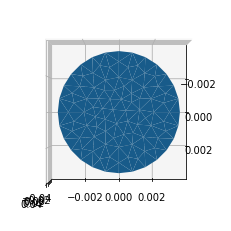

In [25]:
# %% Plotting
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.view_init(azim=0, elev=90)
ax.plot_trisurf(msh.node[:,0],msh.node[:,1],np.zeros_like(msh.node[:,0]))

In [12]:
# Alternative plotting. Here the result is directly 2D. 


In [13]:
## Visualize the regions of the model 

### 3) Define the finite-element shape functions, construct stiffness matrix and load vector 

In [14]:
# Task 4: Calculate the element areas (element_area, numelem-by-1) and the 
# further coefficients a, b and c (each numelem-by-3)
# Define the finite-element shape functions 


In [15]:
# Compute element-wise reluctivity


In [16]:
# Task 4: Construct the stiffness matrix Knu (H−1). Do this at first by looping over all elements. 
# Gather the row numbers, column numbers and matrix entries into vectors i, j, v. 
# At the end, use the class sparse to assemble all entries into a sparse matrix Knu. 
# Show the sparsity pattern of Knu using the function spy


In [17]:
# Task 4: Define load vector j_grid, element-wise current density

In [18]:
# Task 5: First validation is the check of the magnetic energy
r = ...                         # [m]    : radial coordinate
A_analytic = depth*A_z(r)                      # [Tm]   : analytic solution for the magnetic vector potential projected onto the mesh
W_magn_test = ...   # [J]    : magnetic energy (analytic solution, numerical circuit-reluctance matrix)

print('Magnetic energy (analytic solution)           :',W_magn_analytic,'J')
print('Magnetic energy (analytic Az, numerical Knu)  :',W_magn_test,'J')

TypeError: '<' not supported between instances of 'ellipsis' and 'float'

### 4) Enter boundary conditions and solve the system

In [ ]:
...

### 5) Post Process

In [ ]:
#Calculate magnetic flux density
b_field = np.vstack([np.sum(shape_function.c*a[msh.elem_to_node[:]]
                    /(2*shape_function.element_area[:,None]),1)
                    /shape_function.depth,
                    np.sum(shape_function.b*a[msh.elem_to_node[:]]
                    /(2*shape_function.element_area[:,None]),1)
                    /shape_function.depth]).T
b_field_abs = np.linalg.norm(b_field, axis=1)    # [T]    : magnitude of the magnetic flux density

# Plotting 
fig = plt.figure()
ax = fig.add_subplot(111)
tpc = ax.tripcolor(triang, facecolors=b_field_abs)
fig.colorbar(tpc)
ax.triplot(triang, color='black', lw=0.1)
ax.set_aspect('equal', 'box')

# Validity check
W_magn_fe = 1/2*a@Knu@a                                                 # [J]    : magnetic energy
W_magn_fe2 = np.sum(1/2*reluctivity_in_elements*b_field_abs**2
                    *shape_function.element_area*shape_function.depth)  # [J]     : magnetic energy (integrated)
print('Validity Check:')
print('Magnetic energy (analytic solution)                :',W_magn_analytic,'J')
print('Magnetic energy (FE solution)                      :',W_magn_fe,'J')
print('Magnetic energy (numerical solution, integrated)   :',W_magn_fe2,'J')